# Forming Capital Market Expectations: Real GDP Growth

Going through the CFA program, I came to appreciate the breadth of information that all 3 levels provide. However, there were topics I really struggled with. One of those topics was Economics. My first encounter with the topic was in high school, and this battle has continued ever since. Because I knew it was a pain point for me, I made sure the topic was one of the first I tackled through all 3 levels.

In Level 3, one of the goals of the economic sections was show readers how to form their own capital market expectations. In more clear terms: How is the economy doing? Should I invest in something? Where do I invest? How do I invest? To me, all of this was fascinating. One of the primary components of forming your own view was know what to make of Real GDP, particularly growth. 

To further reinforce understanding of Real GDP, its role in the markets and get some more DS under my belt, I wanted to see if I could predict next quarter's Real GDP to arrive at a forecasted growth rate for the economy. I aim to accomplish this by doing the following:

- Use `quandl` to gather macroeconomic data,
- Use `pandas`, `numpy`, `matplotlib.pyplot` to visualize/explore data
- Test data for appropriateness to apply time-series model (stationarity), and
- `statsmodels` to get a time-series model, particularly `SARIMAX`

Real GDP growth will be a crucial data point in other macro views and company valuation, so while it's one data point, it'll be important thing to have later on for future analysis.

<b><u>Concerns:</b></u>
- Data here is affected by <u>look-ahead bias</u>, where data at different points in time may have changed after the fact. For example, an estimate for Q1 GDP may have been announced in Q2, but can be revised. The revised number would then replace the original number, and we lose what the value actually was. 
- This could be addressed by having data time-stamped for points in time and storing that data for later use (<a href="http://quantopian.com/">Quantopian</a> does this <i>beautifully</i>). 
- This bias does affect the performance of the time-series model. 

In [1]:
import sys
def access_keys():
    file = open('my_keys.txt')
    filelines = {}
    for i in file.readlines():
        val = i.replace("'",'').split(': ')
        filelines.update({val[0]:val[1]})
    return filelines

In [2]:
import quandl as q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

key = access_keys()['quandl']

%matplotlib inline
plt.style.use('fivethirtyeight')

# Gathering the data
To get the data, we will use `quandl`. Per their <a href="https://www.quandl.com/">website</a>, they have tons of data available: some free, some only available to instutional investors, some available only by service. Luckily for us, the data we need is all publicly available and should be free.

We could go directly to BEA & FRED, create something to interact with their individual APIs, parse through how they present their data, and get clean data in that way, but `quandl` does these things nicely and neatly. All we need is an API key.

The reason I'm starting the dataset at 1980 is because I wanted to expose the model to a few cycles (<a href="https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States">about 5 recessions are in the data</a>) of varying length and use that data to predict into the future. 

## Get Data

In [3]:
start_date = '1980-01-01'

gdp = q.get('FRED/GDPC1', authtoken=key, start_date=start_date)

## Explore
- Data is in billons
- More info on the numbers here: https://www.quandl.com/data/FRED/GDPC1-Real-Gross-Domestic-Product

In [4]:
gdp.head()

,Value
Date,
1980-01-01,6837.641
1980-04-01,6696.753
1980-07-01,6688.794
1980-10-01,6813.535
1981-01-01,6947.042


In [5]:
gdp.describe()

,Value
count,157.000000
mean,12403.045236
std,3651.695541
min,6688.794000
25%,9257.128000
50%,12662.385000
75%,15666.738000
max,18910.332000


In [6]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 1980-01-01 to 2019-01-01
Data columns (total 1 columns):
Value    157 non-null float64
dtypes: float64(1)
memory usage: 2.5 KB


In [7]:
gdp.isnull().sum()

Value    0
dtype: int64

C:\Users\wband\Anaconda2\envs\python36\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Real GDP (Billions)')

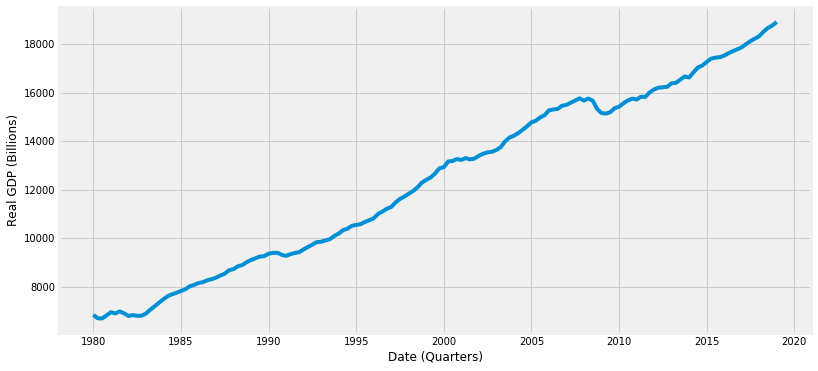

In [8]:
plt.figure(figsize=(12,6))
plt.plot(gdp)
plt.xlabel('Date (Quarters)')
plt.ylabel('Real GDP (Billions)')

## Stationarity
Okay, looking at the graph, it looks like there's positive trending, which means it's likely that the data is not stationary. Doesn't seem like there's seasonality at first glance, however. 

To confirm non-stationarity, let's perform the Augmented Dickey-Fuller test.

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, n_in_season=4):

    #Rolling statistics
    rolmean = timeseries.rolling(window=n_in_season).mean()
    rolstd = timeseries.rolling(window=n_in_season).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, label = 'Original')
    mean = plt.plot(rolmean, label = 'Rolling Mean')
    std = plt.plot(rolstd, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

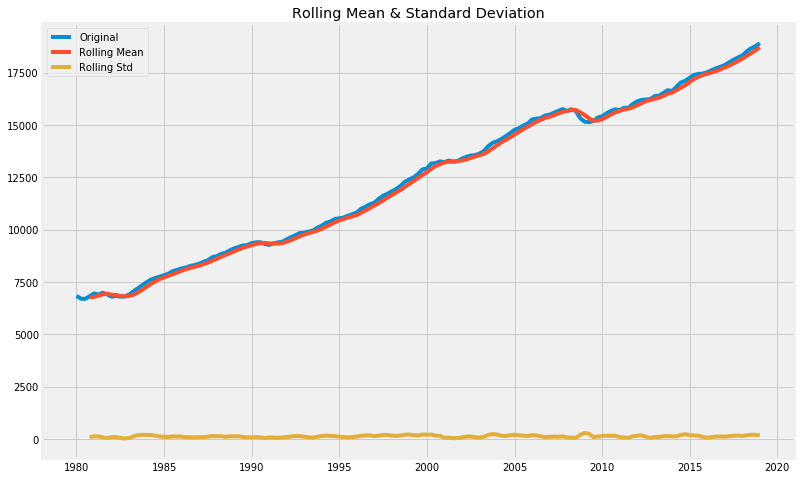

Results of Dickey-Fuller Test:
Test Statistic                   0.384391
p-value                          0.980902
#Lags Used                       2.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


In [10]:
test_stationarity(gdp.Value)

It would seem that the time series is not stationary. This means we need to make it stationary before putting a model on it, and we can do so by differencing or some variations of it. Examples below:

C:\Users\wband\Anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


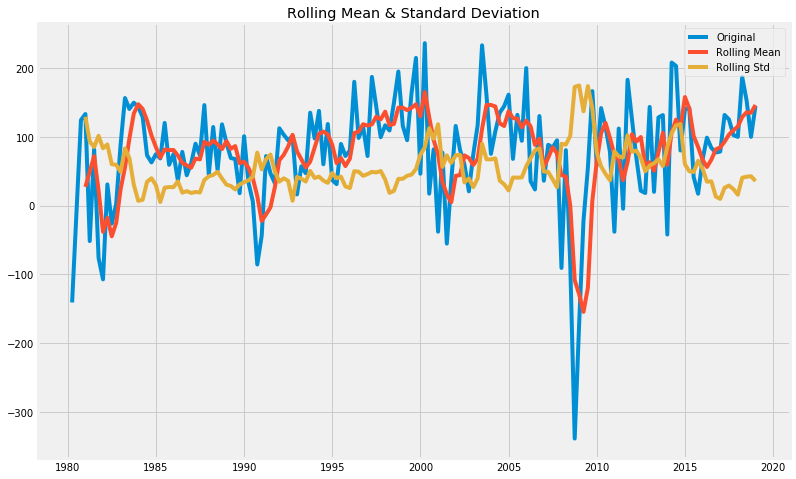

Results of Dickey-Fuller Test:
Test Statistic                -6.015042e+00
p-value                        1.540873e-07
#Lags Used                     1.000000e+00
Number of Observations Used    1.540000e+02
Critical Value (1%)           -3.473543e+00
Critical Value (5%)           -2.880498e+00
Critical Value (10%)          -2.576878e+00
dtype: float64


In [11]:
gdp.first_diff = gdp.Value.diff(periods=1)
test_stationarity(gdp.first_diff.dropna())

By taking the first difference, we were able to make it fairly stationary. If we take the log of the first difference, we would get something like this.

C:\Users\wband\Anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


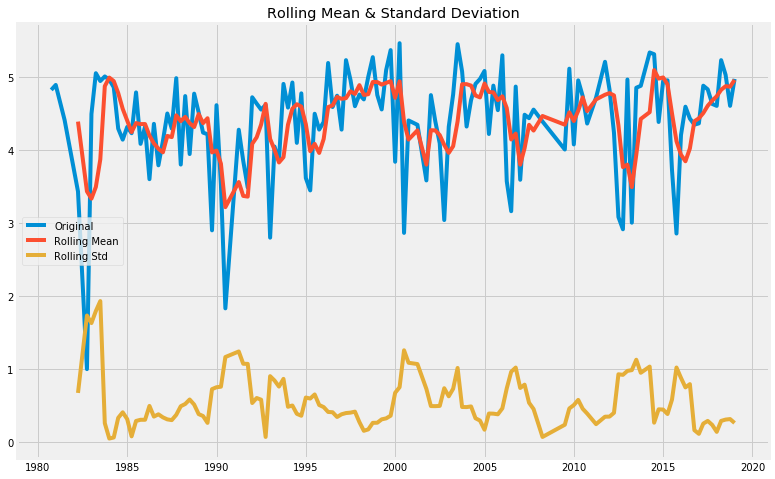

Results of Dickey-Fuller Test:
Test Statistic                -6.766716e+00
p-value                        2.705490e-09
#Lags Used                     1.000000e+00
Number of Observations Used    1.360000e+02
Critical Value (1%)           -3.479372e+00
Critical Value (5%)           -2.883037e+00
Critical Value (10%)          -2.578234e+00
dtype: float64


In [12]:
test_stationarity(np.log(gdp.first_diff).dropna())

Another way to look at this is to use `seasonal_decompose` to break down the time series into 1) Trend, 2) Seasonality, and 3) Residuals (<a href="https://en.wikipedia.org/wiki/Decomposition_of_time_series">more on decomposition</a> here). Based on the visual of GDP over time, the line looks linear and gradually increasing (additive) than multiplicative, so we'll start there.

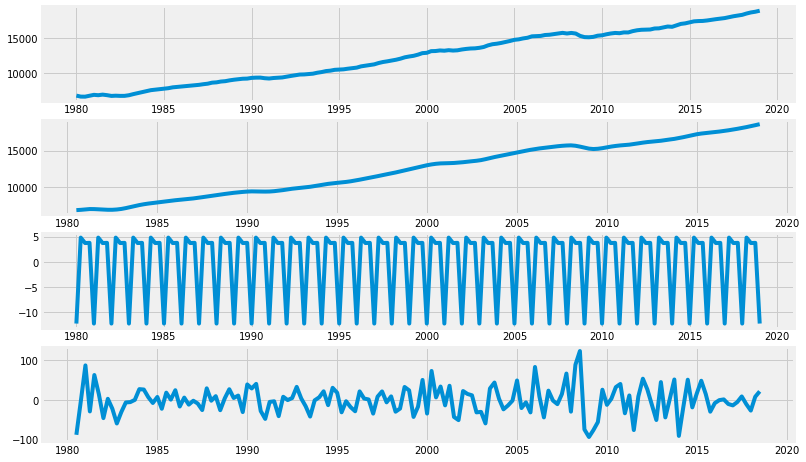

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(12,8))

result = seasonal_decompose(gdp.Value, model='additive')
observed = result.observed
trend = result.trend
seasonal = result.seasonal
residual = result.resid

graph = 1
for i in [observed, trend, seasonal, residual]:
    plt.subplot(4,1,graph)
    plt.plot(i)
    graph += 1

## Model
Based on the above, there does seem to be a postive, linear-ish trend, and quarterly seasonality as well. This would point to using a seasonal model like `SARIMAX`. 

After a few iterations, I came away with the following:
- I looked at different time frames and found that longer time frames produced lower test RMSE. I started the data sets at 1980, 1985, 1990, 1995 and 2009 and saw that more data points produced more accurate forecasts. I think this accomplishes my goal of exposing the model to more business cycles.
- Taking $Log^{2}$ of the data produced lower test RMSE than taking the simple Log and raw values.

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# data = np.log(gdp.Value) ** 2

# start_date = '2009-01-01'
cutoff_date = '2018-04-01'

data_raw = gdp.Value
train_raw = data_raw.loc[:cutoff_date]
test_raw = data_raw.loc[cutoff_date:]

data_log = np.log(gdp.Value)
train_log = data_log.loc[:cutoff_date]
test_log = data_log.loc[cutoff_date:]

data_log_sq = np.log(gdp.Value) ** 2
train_log_sq = data_log_sq.loc[:cutoff_date]
test_log_sq = data_log_sq.loc[cutoff_date:]

To efficiently find the optimal parameters for SARIMAX, we'll perform a grid search over different sets of parameters. We'll be cycling through different combinations of `order`, `seasonal_order` and `trend`.


In [15]:
import itertools
import warnings
warnings.filterwarnings('ignore')

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
trn = ['n','c','ct','t']
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

def best_sarimax(training_data):
    '''
    Take some training data. Find best params for SARIMAX. Return fitted model on data.
    '''
    model_params_df = pd.DataFrame(columns=['AIC','Order','S.Order', 'Trend'])
    aic_list = []
    order_list = []
    seasonal_order_list = []
    trend_list = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            for types in trn:
                mod = SARIMAX(training_data, 
                              order=param,
                              seasonal_order=param_seasonal,
                              trend=types,
                              enforce_stationarity=False,
                              enforce_invertibility=False)

                results = mod.fit()
                aic_list.append(results.aic)
                order_list.append(param)
                seasonal_order_list.append(param_seasonal)
                trend_list.append(types)

    # Make a dataframe to get all params, sort them by best AIC          
    model_params_df['AIC'] = aic_list
    model_params_df['Order'] = order_list
    model_params_df['S.Order'] = seasonal_order_list
    model_params_df['Trend'] = trend_list
    best_params = model_params_df.sort_values(by='AIC', ascending=True)
    best_order = best_params.iloc[0]['Order']
    best_s_order = best_params.iloc[0]['S.Order']
    best_trend = best_params.iloc[0]['Trend']
    
    mod1 = SARIMAX(training_data,
              order=best_order,
              seasonal_order=best_s_order,
              trend=best_trend,
              enforce_stationarity=False,
              enforce_invertibility=False)
    results1 = mod1.fit()
    return results1

In [16]:
results_raw = best_sarimax(train_raw)
print(results_raw.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Value   No. Observations:                  154
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 4)   Log Likelihood                -811.377
Date:                           Mon, 08 Jul 2019   AIC                           1630.753
Time:                                   18:45:29   BIC                           1642.605
Sample:                               01-01-1980   HQIC                          1635.569
                                    - 04-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6364      0.150      4.241      0.000       0.342       0.931
ma.L1         -0.2780      0.174     -1.598

In [17]:
results_log = best_sarimax(train_log)
print(results_log.summary())

                           Statespace Model Results                           
Dep. Variable:                  Value   No. Observations:                  154
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 559.479
Date:                Mon, 08 Jul 2019   AIC                          -1110.959
Time:                        18:47:51   BIC                          -1098.863
Sample:                    01-01-1980   HQIC                         -1106.045
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0060      0.001      5.852      0.000       0.004       0.008
drift      -2.093e-05    1.1e-05     -1.908      0.056   -4.24e-05     5.7e-07
ar.L1          0.3605      0.058      6.186      0.0

In [18]:
results_log_sq = best_sarimax(train_log_sq)
print(results_log_sq.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Value   No. Observations:                  154
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 4)   Log Likelihood                 126.041
Date:                           Mon, 08 Jul 2019   AIC                           -240.083
Time:                                   18:49:51   BIC                           -222.140
Sample:                               01-01-1980   HQIC                          -232.792
                                    - 04-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0373      0.019      2.014      0.044       0.001       0.074
ar.L1          0.7815      0.098      7.997

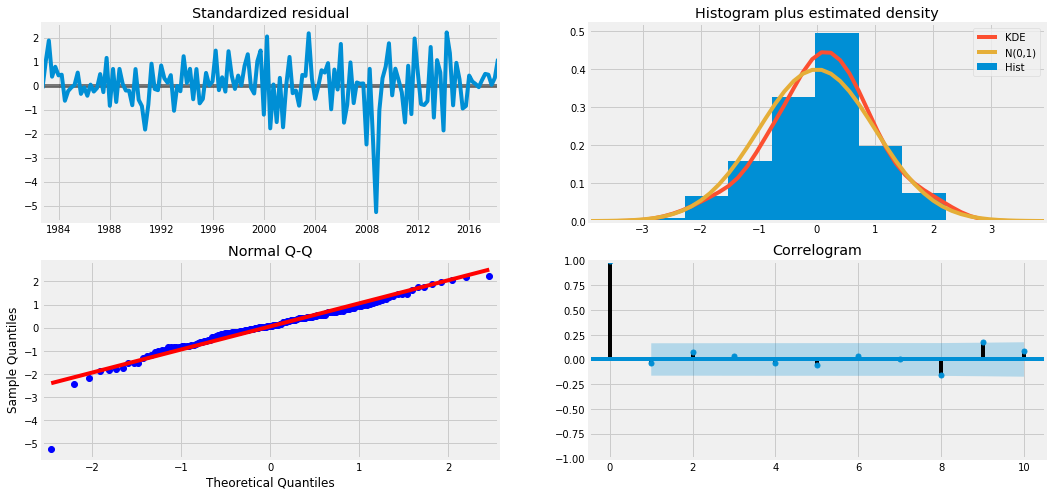

In [19]:
_ = results_raw.plot_diagnostics(figsize=(16, 8))

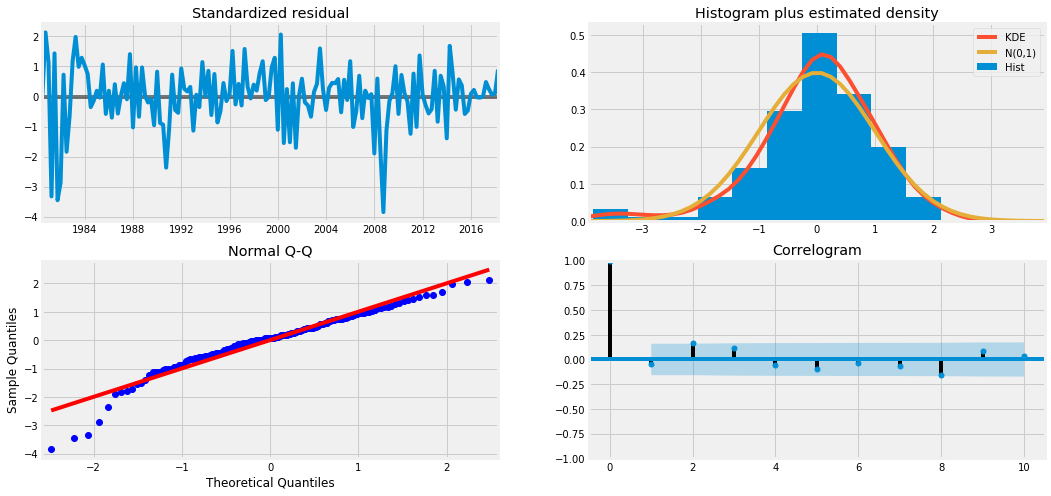

In [20]:
_ = results_log.plot_diagnostics(figsize=(16, 8))

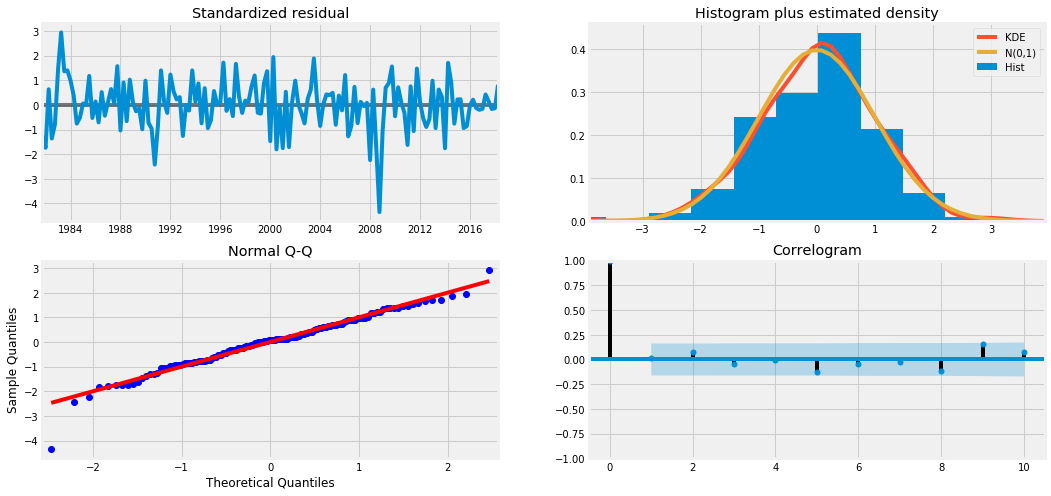

In [21]:
_ = results_log_sq.plot_diagnostics(figsize=(16, 8))

In [22]:
pred_raw = results_raw.get_prediction(start='2018-04-01', end='2019-01-01', dynamic=False)
pred_raw_ci = pred_raw.conf_int()

In [23]:
pred_log = results_log.get_prediction(start='2018-04-01', end='2019-01-01', dynamic=False)
pred_log_ci = pred_log.conf_int()

In [24]:
pred_log_sq = results_log_sq.get_prediction(start='2018-04-01', end='2019-01-01', dynamic=False)
pred_log_sq_ci = pred_log_sq.conf_int()

In [25]:
pred_raw.predicted_mean

2018-04-01    18434.906373
2018-07-01    18629.826480
2018-10-01    18734.217321
2019-01-01    18813.965295
Freq: QS-OCT, dtype: float64

In [26]:
pred_log.predicted_mean

2018-04-01    9.820692
2018-07-01    9.832553
2018-10-01    9.837568
2019-01-01    9.842064
Freq: QS-OCT, dtype: float64

In [27]:
pred_log_sq.predicted_mean

2018-04-01    96.470129
2018-07-01    96.702023
2018-10-01    96.846144
2019-01-01    96.986399
Freq: QS-OCT, dtype: float64

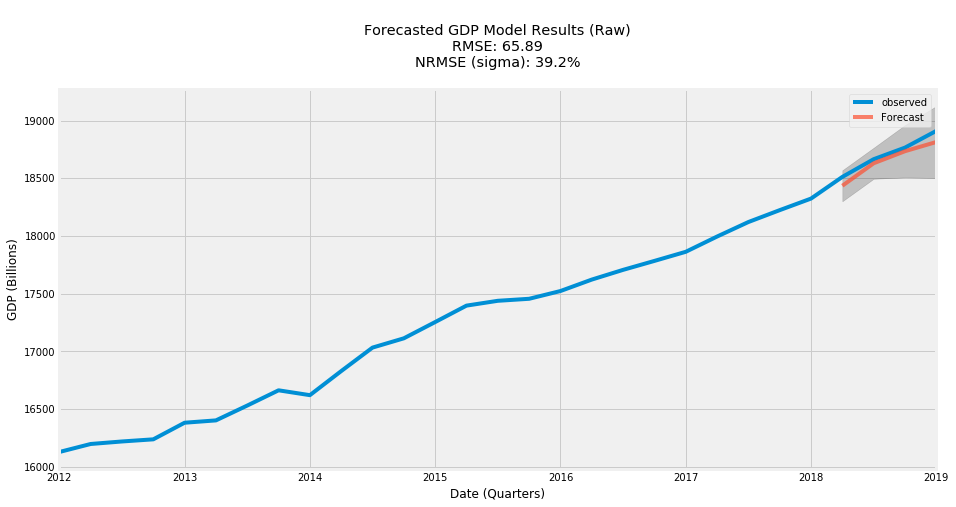

In [28]:
from sklearn.metrics import mean_squared_error, r2_score

title = '''
Forecasted GDP Model Results (Raw)
RMSE: {:.02f}
NRMSE (sigma): {:.01f}%
'''.format(np.sqrt(mean_squared_error(test_raw,pred_raw.predicted_mean)), 
           (np.sqrt(mean_squared_error(test_raw,pred_raw.predicted_mean)) / test_raw.std()) * 100)

plt.title(title)

ax = data_raw['2012-01-01':].plot(label='observed')
pred_raw.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_raw_ci.index,
                pred_raw_ci.iloc[:, 0],
                pred_raw_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date (Quarters)')
ax.set_ylabel('GDP (Billions)')
plt.legend()
plt.show()

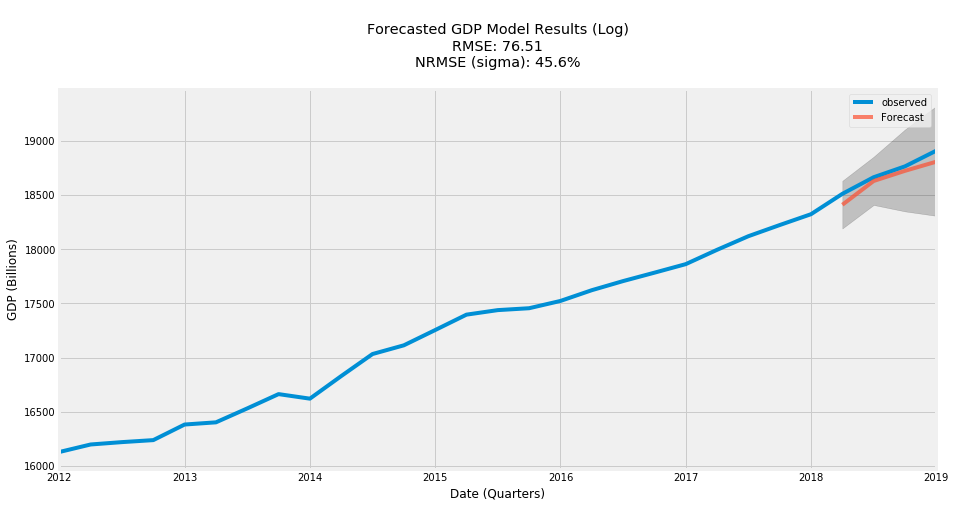

In [29]:
title = '''
Forecasted GDP Model Results (Log)
RMSE: {:.02f}
NRMSE (sigma): {:.01f}%
'''.format(np.sqrt(mean_squared_error(test_raw,np.exp(pred_log.predicted_mean))), 
           (np.sqrt(mean_squared_error(test_raw,np.exp(pred_log.predicted_mean))) / test_raw.std()) * 100)

plt.title(title)

ax = data_raw['2012-01-01':].plot(label='observed')
np.exp(pred_log.predicted_mean).plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_log_ci.index,
                np.exp(pred_log_ci.iloc[:, 0]),
                np.exp(pred_log_ci.iloc[:, 1]), color='k', alpha=.2)
ax.set_xlabel('Date (Quarters)')
ax.set_ylabel('GDP (Billions)')
plt.legend()
plt.show()

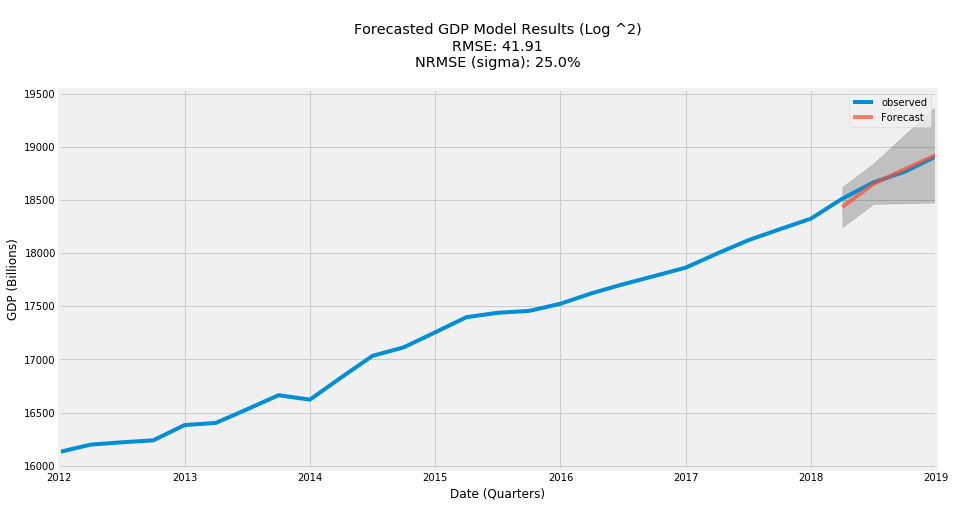

In [30]:
title = '''
Forecasted GDP Model Results (Log ^2)
RMSE: {:.02f}
NRMSE (sigma): {:.01f}%
'''.format(np.sqrt(mean_squared_error(test_raw,np.exp(np.sqrt(pred_log_sq.predicted_mean)))), 
           (np.sqrt(mean_squared_error(test_raw,np.exp(np.sqrt(pred_log_sq.predicted_mean)))) / test_raw.std()) * 100)

plt.title(title)

ax = data_raw['2012-01-01':].plot(label='observed')
np.exp(np.sqrt(pred_log_sq.predicted_mean)).plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_log_sq_ci.index,
                np.exp(np.sqrt(pred_log_sq_ci.iloc[:, 0])),
                np.exp(np.sqrt(pred_log_sq_ci.iloc[:, 1])), color='k', alpha=.2)
ax.set_xlabel('Date (Quarters)')
ax.set_ylabel('GDP (Billions)')
plt.legend()
plt.show()

In [31]:
## Out of sample forecast?
log_preds_sq = results_log_sq.get_forecast(steps=4).predicted_mean[3:]
log_preds_sq

2019-04-01    97.122003
Freq: QS-OCT, dtype: float64

In [32]:
expected = np.exp(np.sqrt(log_preds_sq))
expected

2019-04-01    19054.329721
Freq: QS-OCT, dtype: float64

In [33]:
# Expected quarterly growth? 0.7%
((expected / gdp.Value[-1]) - 1)

2019-04-01    0.007615
Freq: QS-OCT, dtype: float64

In [34]:
# or 3.0% annualized
(((expected / gdp.Value[-1])) ** 4) - 1

2019-04-01    0.030809
Freq: QS-OCT, dtype: float64